In [4]:
!pip install langchain==0.3.24 -q
!pip install -q -U google-generativeai langchain-google-genai
!pip install langchain-community -q
!pip install langgraph -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.9 MB/s eta 0:00:00


In [48]:
!pip install duckduckgo-search -qU
!pip install pyowm -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.0 MB/s eta 0:00:00


In [34]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [35]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [36]:
import os
from google.colab import userdata

google_api_key = userdata.get('GEMINI_API_KEY')

In [37]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    google_api_key=google_api_key,
    temperature=0.9
)

In [38]:
@tool
def addtion(a: int, b:int):
    """This is the addition function that adds 2 numbers"""
    return a + b

@tool
def subtraction(a: int, b: int):
    """This is the subtraction function that subtract 2 numbers"""
    return a - b

@tool
def multiplication(a: int, b: int):
    """This is the multiplication function that multiply 2 numbers"""
    return a * b

@tool
def division(a: int, b: int):
    """This is the division function that divide 2 numbers"""
    return a / b

In [49]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain.agents import load_tools

os.environ["OPENWEATHERMAP_API_KEY"] = userdata.get('OPENWEATHERMAP_API_KEY')

# Initialize DuckDuckGo search tool
search_tool = DuckDuckGoSearchRun()

# Initialize OpenWeatherMap tool
weather = OpenWeatherMapAPIWrapper()

weather_tool = load_tools(["openweathermap-api"], llm)[0]

In [50]:
tools = [addtion, subtraction, multiplication, division, search_tool, weather_tool]

In [51]:
llm_with_tools = llm.bind_tools(tools)

In [52]:
def llm_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are an intelligent AI assistant, please answer my query."
    )
    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def decision(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1] #seen within the last message
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [53]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", llm_call)
tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    decision,
    {
        "continue": "tools",
        "end": END,
    },
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

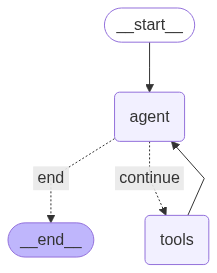

In [54]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [55]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [56]:
inputs = {"messages": [("user", "Add 40 and 12.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 and 12.
================================== Ai Message ==================================
Tool Calls:
  addtion (1863225a-3c57-4a34-bb50-95f8da4c9dd6)
 Call ID: 1863225a-3c57-4a34-bb50-95f8da4c9dd6
  Args:
    a: 40.0
    b: 12.0
================================= Tool Message =================================
Name: addtion

52
================================== Ai Message ==================================

The sum of 40 and 12 is 52.


In [57]:
inputs = {"messages": [("user", "Add 40 and 12. Then multiply the result by 6.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 and 12. Then multiply the result by 6.
================================== Ai Message ==================================
Tool Calls:
  addtion (438e071b-dd32-4805-a334-99ed4274f3ed)
 Call ID: 438e071b-dd32-4805-a334-99ed4274f3ed
  Args:
    a: 40.0
    b: 12.0
================================= Tool Message =================================
Name: addtion

52
================================== Ai Message ==================================
Tool Calls:
  multiplication (1d0aa336-e93a-4503-a620-07d0b807d289)
 Call ID: 1d0aa336-e93a-4503-a620-07d0b807d289
  Args:
    a: 52.0
    b: 6.0
================================= Tool Message =================================
Name: multiplication

312
================================== Ai Message ==================================

The answer is 312.


In [60]:
inputs = {"messages": [("user", "What is the University of Peradeniya?")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the Univercity of Peradeniya?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (06bcf788-b0a2-4899-b8ba-87ee1e3836db)
 Call ID: 06bcf788-b0a2-4899-b8ba-87ee1e3836db
  Args:
    query: University of Peradeniya
================================= Tool Message =================================
Name: duckduckgo_search

The University of Peradeniya has expanded its operational capabilities with the recent acquisition of a backhoe loader machine, valued approximately at Rs. 24 million. This essential addition, funded by the Treasury, will support the university's extensive infrastructure needs across its 1700-acre premises. The official handover ceremony took ... The Department of Management Studies at the University of Peradeniya was established in 2002, with the aim of improving degree programmes with a management focus. Specific programmes

In [61]:
inputs = {"messages": [("user", "What is the current temperature in Colombo?")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the current temperature in Colombo?
================================== Ai Message ==================================
Tool Calls:
  open_weather_map (74818746-1912-4e3c-8eea-fdde2e9c81a9)
 Call ID: 74818746-1912-4e3c-8eea-fdde2e9c81a9
  Args:
    location: Colombo
================================= Tool Message =================================
Name: open_weather_map

In Colombo, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 5.65 m/s, direction: 228°
Humidity: 77%
Temperature: 
  - Current: 28.91°C
  - High: 28.97°C
  - Low: 28.91°C
  - Feels like: 33.87°C
Rain: {}
Heat index: None
Cloud cover: 93%
================================== Ai Message ==================================

The current temperature in Colombo is 28.91°C.
